# THEORY OF APPROXIMATE REACTION NETWORKS

In [44]:
import numpy as np
import pandas as pd
import tellurium as te
import controlSBML as ctl
import control
import matplotlib.pyplot as plt
import sympy as sp

# Helpers 

In [2]:
TEST_MODEL = """
model *main()
$SI -> SO; TEST_KIO*SI
SO ->; TEST_KO*SO

SI = 0
TEST_KIO = 2
TEST_KO = 1
end
"""

In [3]:
TEST_KIO = 2
TEST_KO = 1
TEST_TF = control.TransferFunction([TEST_KIO], [1, TEST_KO])

In [4]:
def plotStep(model=None, tf=None, title="", figsize=(8, 8), is_plot=True, **kwargs):
    """
    Assumes that input is SI and output is SO

    Args:

    Returns:
        np.array (data from simulation)
        np.array (predictions)
    """
    if "SI" in kwargs.keys():
        SI = kwargs["SI"]
    else:
        raise ValueError("Must specify input SI")
    #
    _, ax = plt.subplots(1, figsize=figsize)
    if model is not None:
        rr = te.loada(model)
        for key, value in kwargs.items():
            rr[key] = value
        selections = ["time", "SO"]
        data = rr.simulate(selections=selections)
    else:
        data = None
    if data is None:
            times = np.linspace(0, 5, 50)
    else:
        times = data["time"]
    if tf is not None:
        times, predictions = control.step_response(tf, T=times)
        predictions = SI*predictions
    else:
        predictions = None
    if (tf is not None) and (model is not None):
        ax.scatter(data[:, 1], predictions, color="red", marker="*")
        ax.set_xlabel("simulated")
        ax.set_ylabel("predicted")
        max_simulated = np.max(data[:, 1])
        max_predictions = np.max(predictions)
        max_value = max(max_simulated, max_predictions)
        ax.plot([0, max_value], [0, max_value], linestyle="--")
    else:
        if data is not None:
            ax.scatter(times, data[:, 1], marker="o")
            ax.set_xlabel("time")
            ax.set_ylabel("simulations")
        elif predictions is not None:
            ax.scatter(times, predictions, marker="o")
            ax.set_xlabel("time")
            ax.set_ylabel("predictions")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return data, predictions

# Tests
is_plot = False
data, _ = plotStep(model=TEST_MODEL, SI=5, TEST_KIO=TEST_KIO, TEST_KO=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
assert(data[-1, 1] > 0)
_ = plotStep(SI=5, tf=TEST_TF, TEST_K12=TEST_KIO, TEST_K2=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
_ = plotStep(model=TEST_MODEL, SI=5, tf=TEST_TF, TEST_KIO=TEST_KIO, TEST_KO=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
print("OK!")

OK!


# Theory

The idea is to develop transfer functions based on an algebra on reaction networks.
**Outline**
1. Consider the network
  * $S_1 \rightarrow S_2$ at rate $k_{1,2}S_1$
  * $S_2 \rightarrow ∅$ at rate $k_2 S_2$
1. The foregoing has the transfer function $\frac{k_2}{s + k_{1,2}}$.
1. Creating a sequential path of networks multiplies their transfer functions. The result is a composite system that has all the poles and zeroes of the component systems.
1. Summing the outputs (two paths to equivalent chemical species) adds transfer functions. The result is a composite system that has the poles of the component systems but different zeroes.
1. Feedback transforms the poles of a transfer function.

**Claim**. Given a proper transfer function whose numerator and denominator are polynomials with real coefficients, we can construct a reaction network with the given transfer function.

**Implications**
1. Can design oscillators.
1. Can approximate reaction networks.
1. Have an understanding of poles and zeros.

## Concepts and notation

We use subscripted and superscripted $S$ to indicate chemical species. Where there is no confusion, we use the same symbol for its concentration as well. In contexts where there may be confusion between the name and its concentration, we explicitly indicate a concentration using square brackets. For example, $[S_0]$ is the concentration of species $S_0$.

* A (uni-uni) **reaction** is a triple expressed as $S_I \xrightarrow{k} S_O$ indicates the transformation of mass from species $S_I$ to $S_O$ using mass action with the kinetic constant $k$. If $k < 0$, then $S_O$ is transformed into $S_I$; that is, $S_O \xrightarrow{-k} S_I$. If $S_I = \emptyset$ or $S_O = \emptyset$, then this a boundary reaction. For an input boundary, $k_I$ is a fixed rate. If $S_O = \emptyset$, then this is a degradation reaction.

* A **SISO Reaction Network (SRN)** is $N = <S, S_I, S_O, R, k_I, k_O>$ where:
    * $S$ is a set of chemical species
    * $S_I, S_O \in S$ are input and output species.
    * $R$ is a set of reactions.
    * $k_I S_I$ is the rate at which the input is consumed.
    * $k_O S_O$ is the rate at which the output is degraded.

* We indicate components of an object using a dot ("."), such as $N.S_I$


## Network Operations

These are operations applied to SISO reaction networks that produce a new SISO reaction network.
In the sequel, $N^A, N^B$ are SRNs.

**Sequence** is an asymmetric, binary operation.
Let $N$,, $N^A, N^B$ be SISO reaction networks such that $N^A.S \bigcap N^B.S = \{N^A.S_O = S^B.S_I \}$. 
Sequence applied these SRNs, denoted by $N = N^A \circ  N^B$, is:
* $S = N^A.S \bigcup N^B.S$
* $S_I =N^A.S_I$
* $S_O = N^B.S_O$
* $R = R^A \bigcup R^B$
* $k_I = N^A.k_I$
* $k_O = N^B.k_O$

**Forkjoin** is a symmetric, binary operation.
Assume that $N^A.S \bigcap N^B.S = \{N^A.S_I\} = \{N_B.S_I \}$.
The forkjoin of these networks, denoted by $N = N^A + N^B$, is:
* $S = N^A.S \bigcup N^B.S \bigcup \{ O \}$
* $S_I = N^A.S_I = N^B.S_I$
* $S_O$ is a new species defined as $\{ N^A.S_O, N^B.S_O\}$
* $R = R^A \bigcup R^B$
* $k_I = N^A.k_I + N^B.k_I$
* $k_O = N^A.k_O + N^B.k_O$

**Amplify** is a unary operation.
$amplify(N, K, k)$, $0 \lt K, k$. $[S_O] = K[N.S_O]$.
* $S = N.S$
* $S_I = N.S_I$
* $S_O = N.S_O$
* $R = N.R \bigcup \{N.S_I \xrightarrow{k} N.S_O,~ N.S_O \xrightarrow{Kk} N.S_I \}$
* $k_I = N.k_I + \frac{1}{k}$
* $k_O = N.k_O + \frac{K}{k}$

**Loop** is a unary operation.
$loop(N, S_I, S_O, k_1, k_2, k)$ is a unary operation, where: $k$ is real. The loop operation is similar to electrical circuits that use an operational amplifier.
* $S = N.S \bigcup \{S_I, S_O \}$
* $R = R \bigcup \{S_I \xrightarrow{k_1} N.S_I,~ N.S_O \xrightarrow{k} N.S_I,~ N.S_O \xrightarrow{k_2} S_O \}$
* $k_I = N.k_I$
* $k_O = N.k_O + k$

**Insulate** is a unary operation that separates a network from its environment.
$insulate(N, S_I, S_O, k_1, k_2)$ is a unary operation.
* $S = N.S \bigcup \{S_I, S_O \}$
* $R = R \bigcup \{S_I \xrightarrow{k_1} N.S_I,~ N.S_O \xrightarrow{k_2} S_O \}$
* $k_I = k_1$
* $k_O = 0$

Note that we can just insulate the input by setting $k_2 = 0$, and simularly, just insulate the output by $k_1 = 0$.

**Instantiate** is a uniary operation.
$instantiate(N)$ creates a network with the same reaction and kinetic constants but unique species.

In [15]:
!pwd

/Users/jlheller/home/Technical/repos/network_approximations/notebooks


**Loop**. Elements inside the outer box are in the network being looped. Note that $N.S_I, N.S_O$ are shared between the inside and outside of the network.

<img src="images/loop.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

## Networks

### Two Species Reaction Network (2SRN)

* $S = \{S_I, S_O\}$
* $R = \{ S_I \xrightarrow{k_{IO}} S_O, S_O \xrightarrow{k_O} ∅ \}$
* $k_I = k_{IO}$
* $k_O = k_{O}$

Claim that the transfer function from $S_I$ to $S_O$ is $\frac{k_I + k_{IO}}{s + k_O}$.

### Sequence two 2SBNs

Let $N^A$, $N^B$ be 2SBN with $S^A.S_O = S^B.S_I$.
Then $N = N^A \circ N^B$ has the following properties:
* $S = \{S^A_I, S^A_O = S^B_I, S^B_O \}$
* $R = R^A \bigcup R^B$
* $S_I = S^A_I$
* $S_O = S^B_O$
* $k_I = N^A.k_I$
* $k_O = k^B_O$

$N$
has transfer function $H(s)$
$$H(s) = H^A(s) H^B(s)\frac{s + k^A_O}{s+ k^B_I + k^A_O}$$.

### Forkjoin two 2SBNs

Let $N^A$, $N^B$ be 2SBN with $S^A.S_I = S^B.S_I$.
Then $N = N^A + N^B$ has the following properties:
* $S = \{S^A_O, S^A.S_I = S^B.S_I, S^B_O \}$
* $R = R^A \bigcup R^B$
* $S_I = S^A.S_I = S^B.S_I$
* $S_O = \{ S^A.S_O, S^B.S_O \}$
* $k_I = k^A_I + k^B_I$
* $k_O = k^A_O + k^B_O$

$N$
has transfer function $H(s)$
$$H(s) = H^A(s) + H^B(s)$$.

## Claims

1. **Transfer function for sequence**. Let $N_1, N_2$ be reaction networks with transfer functions $H_1(s), H_2(s)$ that satisfy the conditions for concatenation. Let $N = N_1 \circ N_2$, and let $H(s)$ be its transfer function. Claim that $H(s) = H_1 (s) H_2(s)\frac{s + N^A.k_O}{s + N^A.k_O + N^B.k_I}$.
1. **Transfer function for forkjoin**. Let $N_1, N_2$ be reaction networks with transfer functions $H_1(s), H_2(s)$ that satisfy the conditions for branching. Let $H(s)$ be the transfer function for $N_1 + N_2$. Claim that $H(s) = H_1 (s) + H_2(s)$.
1. **Transfer function for scale**. Let $N_1$ be a reaction network with transfer function $H_1(s)$. Let $N  = K \times N_1$, and $H(s)$ be its transfer function. Claim that $H(s) = kH_1(s)$.

1. **Transfer function for loop**. Given, $N$, its transfer function $G(s) = \frac{N(s)}{D(s)}$. Find $S_O(s) = H(s) S_I(s)$ for $loop(N, k)$.

Below are the basic equations.
\begin{eqnarray}
s S_O (s) & = & k_4 X_O (s)  \\
s X_I (s) & = & k_5 X_O(s) + k_1 S_I (s) - k_2 X_I (s) \\
X_I(s) & = & \frac{k_5 X_O(s) + k_1 S_I (s)}{s + k_2} \\
s N.S_I (s) & = & k_2 X_I(s) - N.k_I N.S_I(s) \\
N.S_I(s) & = & \frac{k_2 X_I(s)}{s + k^N_I} \\
N.S_O (s) & = &  G(s) \frac{s + k^N_O}{ s + k^N_O + k_3} N.S_I(s)\\
\end{eqnarray}
However, with this conversion, the relationship between $N.S_I$ and $N.S_O$ must be adjusted since we have concatenated two chemical systems.
\begin{eqnarray}
s X_O (s) & = & -k_4 X_O (s) - k_5 X_O (s) + k_3 N.S_O(s) \\
s X_O (s) & = & -k_4 X_O (s) - k_5 X_O (s) + k_3  G(s) \frac{s + k^N_O}{ s + k^N_O + k_3} N.S_I(s) \\
& = &   -k_4 X_O (s) - k_5 X_O (s) +
  k_2 k_3  G(s) \frac{s + k_O^N}{(s + k^N_O + k_3)(s + k^N_I)} X_I(s) \\
& = &   -k_4 X_O (s) - k_5 X_O (s) +
k_2 k_3  G^{\prime}(s)X_I(s) \\
\end{eqnarray}
In the sequel, $G^{\prime}(s) =  G(s) \frac{s + k^N_O}{(s + k^N_O + k_3)(s + k^N_I)}$.

**Changed $N.S_O(s)$, but no change in the equations?**

\begin{eqnarray}
X_O (s) & = & \frac{k_2 k_3  G^{\prime} (s) X_I(s)}{s + k_4 + k_5}  \\
  &= &  \frac{k_2 k_3  G^{\prime} (s)}{s + k_4 + k_5} \frac{k_5 X_O(s) + k_1 S_I (s)}{s + k_2} \\
X_O (s) (s + k_2) (s + k_4 + k_5)  & = & 
  k_5 X_O(s) k_2 k_3  G^{\prime}(s) + k_1 S_I (s) k_2 k_3 G^{\prime}(s) \\
X_0 (s) & = & \frac{ k_1  k_2 k_3 G^{\prime}(s) S_I (s)}
{(s + k_2) (s + k_4 + k_5) - k_2 k_3 k_5 G^{\prime} (s) } \\
S_O (s) & = & \frac{k_4}{s} \frac{ k_1  k_2 k_3 G^{\prime}(s) S_I (s)}
  {(s + k_2) (s + k_4 + k_5) - k_2 k_3 k_5 G^{\prime}(s)} \\
   & = & \frac{ k_1  k_2 k_3 k_4 G^{\prime}(s) S_I (s)}
  {s \lbrack (s + k_2) (s + k_4 + k_5) - k_2 k_3 k_5 G^{\prime} (s) \rbrack } \\
H(s) & = & \frac{ k_1  k_2 k_3 k_4 G^{\prime} (s)}
  {s \lbrack (s + k_2) (s + k_4 + k_5) - k_2 k_3 k_5 G^{\prime} (s) \rbrack } \\
  & = & \frac{ K_1 G^{\prime} (s)}
  {s D(s) - s K_2 G^{\prime} (s)  } \\
\end{eqnarray}
where $K_1 = k_1 k_2 k_3 k_4$, $K_2 = k_2 k_3 k_5$, $D(s) = (s + k_2) (s + k_4 + k_5)$.

Observe that:
1. How do I relate $X_I$ to $N.S_I$? Know $N.k_I$ and assume that no backward flows to $N.S_I$.
1. If $k, k_2 \rightarrow 0$, then the denominator is 0, and the system "blows up".
2. If $k \rightarrow 0$, then we have a zero at 0 and a new pole.
3. Clean up the symbols. Use $X_I, X_O$.
4. The expression is strange because the step response should not be finite. Missing a 1/s? Have a problem with the slope as well.
5. Have I properly captured the role of $G(s)$ in sX_O(s)? $N.S_I(s) G(s) = N.S_O(s)$; $k_2 X_I(s) = s N.S_I(s)$; $s X_O(s) = k_3 N.S_O(s)$. So,
\begin{eqnarray}
s X_O (s) & = & -k_4 X_O (s) - k_5 X_O (s) + \frac{1}{s}k_2 X_I(s) G^{\prime} s) \\
\end{eqnarray}

## Notes
1. Apply insulate consistently.

# Numerical Studies

## Sequence

For all models, S1 is the input and S2 is the output.

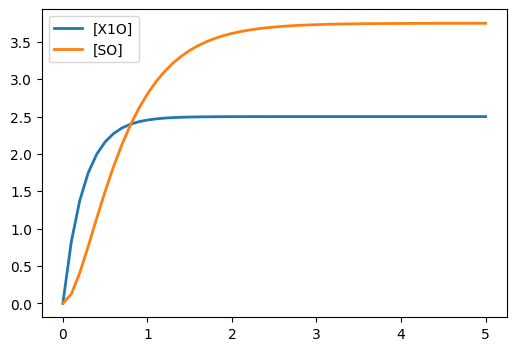

In [5]:
model_sequence = """
model *main()
$SI -> X1O; k12*SI
X1O ->; k2*X1O
X1O -> SO; k23*X1O
SO -> ; k3*SO

SI =5
k12 = 2
k2 = 1
k23 = 3
k3 = 2
end
"""
rr = te.loada(model_sequence)
rr.simulate()
rr.plot()

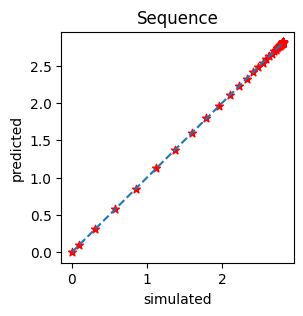

In [6]:
k12 = 1.5
k2 = 1
k23 = 3
k3 = 2
SI = 5
tf1 = control.TransferFunction([k12], [1, k2])
tf2 = control.TransferFunction([k23], [1, k3])
tf3 = control.TransferFunction([1, k2], [1, k2+k23 ])
# tf3 adjusts for the consumption of S2 by the second network
tf = tf1*tf2*tf3
_ = plotStep(model=model_sequence, tf=tf, SI=SI, k12=k12, k2=k2, k23=k23, k3=k3, title="Sequence", figsize=(3, 3))
# _ = plotStep(tf=tf, SI=SI, k12=k12, k2=k2, k23=k23, k3=k3, title="Sequence", figsize=(3, 3))

## Forkjoin

In [7]:
model_forkjoin = """
model *main()
$SI -> S2A; k12A*SI
S2A ->; k2A*S2A
$SI -> S2B; k12B*SI
S2B ->; k2B*S2B
SO := S2A + S2B
SI =5
k12A =3
k12B = 2
k2A = 2
k2B = 2
S2A = 0
S2B = 0
end
"""

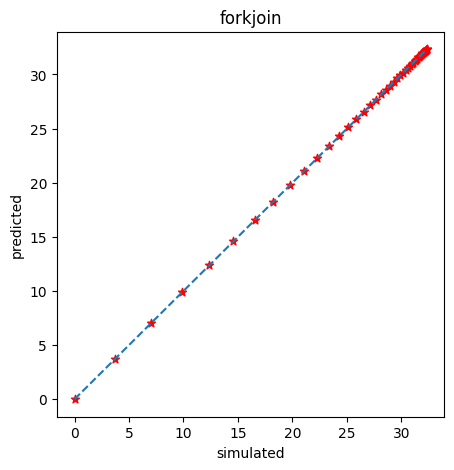

In [8]:
k12A = 5
k2A = 1
k12B = 3
k2B = 2
S1 = 5
tf1 = control.TransferFunction([k12A], [1, k2A])
tf2 = control.TransferFunction([k12B], [1, k2B])
tf = tf1 + tf2
_ = plotStep(model=model_forkjoin, tf=tf, SI=SI, k12A=k12A, k2A=k2A, k12B=k12B, k2B=k2B, title="forkjoin", figsize=(5,5))

## Loop

\begin{eqnarray}
H(s) & = & \frac{ k_1  k_2 k_3 k_4 G(s)}
{s \left( s^2 + (k_2 + k_4 +k_5)s + k_2 k_4 + k_2 k_ 5 - k_2 k_3 k_5 G(s) \right)} \\
\end{eqnarray}


In [302]:
# Get correct poles and zeroes. So problem is with the math.
# 
def loopTransferFunction(model_tf, k1, k2, k3, k4, k5, knI, knO):
    """
    Constructs the transfer function from S_I to S_O for the loop operation.

    Args:
        model_tf: Transfer function (of the network being looped)
        k1, k2, k3, k4, k5: float (Parameters of the loop operation)
        kn: float (k_O^N, degradation constant for the output of the network being looped)
    """
    # Calculate terms
    s = control.TransferFunction.s
    K1 = k1*k2*k3*k4
    K2 = k2*k3*k5
    D1 = control.TransferFunction([1, k2], [1])
    D2 = control.TransferFunction([1, k4+k5], [1])
    D = D1*D2
    C = control.TransferFunction([1], [1, knI])*control.TransferFunction([1, knO], [1, knO + k3])
    # Denominator
    denom_tf = s*(D - K2*C*model_tf)
    numr_tf = K1*C*model_tf
    #
    tf = numr_tf/denom_tf
    return tf

# Tests
model_tf = control.TransferFunction([1], [1, 1])
model_tf = control.TransferFunction([1], [1])
k1 = 1; k2 = 1; k3 =1; k4 =1; k5 = 0.8; knO=2; knI=1
tf = loopTransferFunction(model_tf, k1, k2, k3, k4, k5, knI, knO) 
assert(isinstance(tf, control.TransferFunction))
print("OK!")

OK!


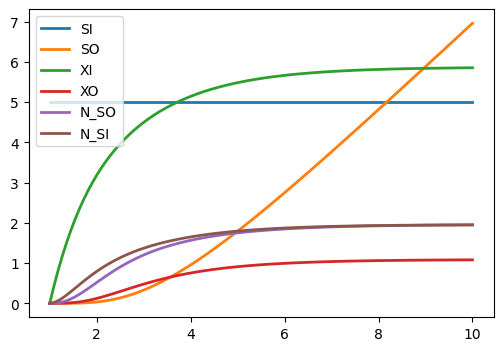

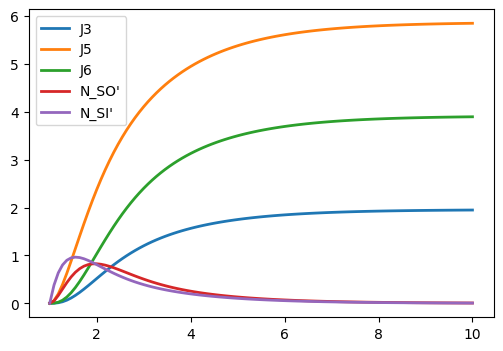

In [297]:
# The looped network is S1A -> S2A, S2A ->;
model_loop = """
model *main()
species XO;
// Reactions external to looped network
J__SI__XI: $SI -> XI; k1*SI
J__XI__N_SI: XI -> N_SI; k2*XI
J3: N_SO -> XO; k3*N_SO
J4: XO -> SO; k4*XO
// Looped network
J5: N_SI -> N_SO; kIO*N_SI
J6: N_SO -> ; kO*N_SO
// Added reactions
J7: XO -> XI; k5*XO
SI =5
N_SI = 0
N_SO = 0
SO = 0
#
k1 = 1
k2 = 1
k3 = 1
k4 = 1
k5 = 0.8
kIO = 3
kO = 2
end
"""
rr = te.loada(model_loop)
data_S = rr.simulate(1, 10, 100, selections=["time", "SI", "SO", "XI", "XO", "N_SO", "N_SI"])
rr.plot()
rr.reset()
#rr.simulate(1, 10, 100, selections=["time", "J1", "J2", "J3", "J4", "J5", "J6", "J7"])
data_J = rr.simulate(1, 10, 100, selections=["time", "J3", "J5", "J6", "N_SO'", "N_SI'"])
rr.plot()

\begin{eqnarray}
s S_O (s) & = & k_4 X_O (s)  \\
s X_I (s) & = & k_5 X_O(s) + k_1 S_I (s) - k_2 X_I (s) \\
s N.S_I (s) & = & k_2 X_I(s) - N.k_I N.S_I(s) \\
\end{eqnarray}

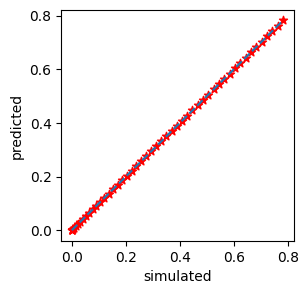

In [306]:
k1 = 1; k2 = 10; k3 = 1; k4=1; k5=0.2
kIO = 10; kO =20; SI=5
inner_tf = control.TransferFunction([kIO], [1, kO])
tf = loopTransferFunction(inner_tf, k1, k2, k3, k4, k5, kIO, kO)
#_ = plotStep(model=model_loop, tf=tf, figsize=(3, 3), k=k, k1=k1, k2=k2, SI=SI, kIO=kIO, kO=kO)
#_ = plotStep(model=model_loop, figsize=(3, 3), k1=k1, k2=k2, k3=k3, k4=k4, k5=k5, SI=SI, kIO=kIO, kO=kO)
#_ = plotStep( tf=tf, figsize=(3, 3), k1=k1, k2=k2, k3=k3, k4=k4, k5=k5, SI=SI, kIO=kIO, kO=kO)
_ = plotStep(model=model_loop, tf=tf, figsize=(3, 3), k1=k1, k2=k2, k3=k3, k4=k4, k5=k5, SI=SI, kIO=kIO, kO=kO)

### Debugging

In [298]:
k1 = 1; k2 = 1; k3 = 1; k4 = 1; kIO = 3; kO =2; SI=5; k5 = 0.8
inner_tf = control.TransferFunction([kIO], [1, kO])
adj_inner_tf = inner_tf*control.TransferFunction([1, kO], [1, kO + k3])  # Adjust TF for conversion to XO
times, N_SO = control.forced_response(adj_inner_tf, T=data_S["time"],  U=data_S["N_SI"])

In [300]:
# Compare simulation results with predictions for the sN.S_I(s) formula
dN_SI = k2*data_S["XI"] - kIO*data_S["N_SI"]
dN_SI - data_J["N_SI'"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

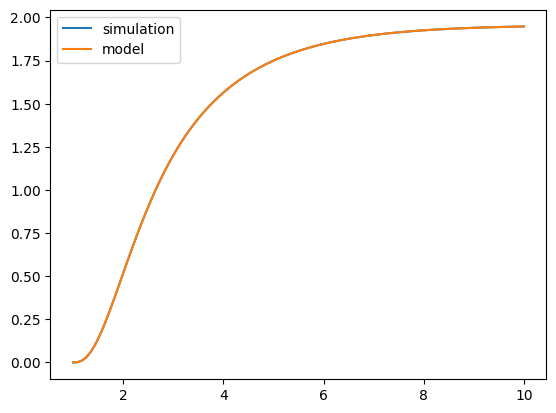

In [301]:
# Compare simulation results with predictions for the sN.S_O(s) formula
#dN_SO = predictions - k3*data_S["N_SO"]  # Formula in analysis
data_S["N_SO"] - N_SO
plt.plot(times, data_S["N_SO"])
plt.plot(times, N_SO)
plt.legend(["simulation", "model"])

In [282]:
# Is the transfer function correct?
data_S["N_SO"] - predictions

array([ 0.00000000e+00, -7.50672860e-04, -1.57151589e-03, -3.34265647e-03,
       -6.95791219e-03, -1.31436612e-02, -2.23888782e-02, -3.49386228e-02,
       -5.08217777e-02, -6.98929770e-02, -9.18778781e-02, -1.16416136e-01,
       -1.43098830e-01, -1.71497928e-01, -2.01189603e-01, -2.31770780e-01,
       -2.62870342e-01, -2.94156049e-01, -3.25337757e-01, -3.56167949e-01,
       -3.86440565e-01, -4.15988439e-01, -4.44679866e-01, -4.72414883e-01,
       -4.99121754e-01, -5.24752855e-01, -5.49280653e-01, -5.72694290e-01,
       -5.94996722e-01, -6.16202131e-01, -6.36333505e-01, -6.55420483e-01,
       -6.73497558e-01, -6.90602653e-01, -7.06775960e-01, -7.22058972e-01,
       -7.36493664e-01, -7.50121846e-01, -7.62984719e-01, -7.75122490e-01,
       -7.86574152e-01, -7.97377245e-01, -8.07567762e-01, -8.17180018e-01,
       -8.26246725e-01, -8.34798862e-01, -8.42865829e-01, -8.50475435e-01,
       -8.57653903e-01, -8.64426018e-01, -8.70815110e-01, -8.76843161e-01,
       -8.82530895e-01, -